In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load dataset
df = pd.read_csv('../data/processed_tx_data.csv')

# Drop non-numeric columns
X = df.drop(columns=['Blockno', 'UnixTimestamp'])

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Split for training/validation
X_train, X_val = train_test_split(X_tensor, test_size=0.2, random_state=42)


In [ ]:
# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder(input_dim=X.shape[1])


In [4]:
# train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output, X_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")


Epoch 0 - Loss: 0.8556
Epoch 10 - Loss: 0.8433
Epoch 20 - Loss: 0.8292
Epoch 30 - Loss: 0.8130
Epoch 40 - Loss: 0.7938


In [5]:
# Compute Anomaly Scores
model.eval()
with torch.no_grad():
    reconstructed = model(X_tensor)
    reconstruction_error = torch.mean((X_tensor - reconstructed) ** 2, dim=1)

# Add anomaly score to original DataFrame
df['recon_error'] = reconstruction_error.numpy()

# Use a threshold (top 1% as anomalies)
threshold = np.percentile(df['recon_error'], 99)
df['autoencoder_anomaly'] = (df['recon_error'] > threshold).astype(int)

print("Anomalies detected:", df['autoencoder_anomaly'].sum())


Anomalies detected: 50


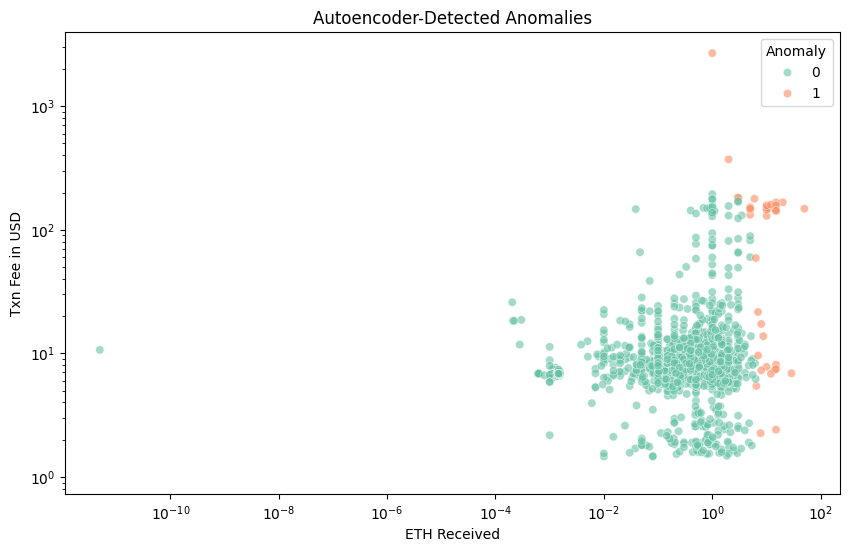

In [6]:
# visualise autoencodeer anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Value_IN(ETH)', y='TxnFee_USD', hue='autoencoder_anomaly', data=df, palette='Set2', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.title("Autoencoder-Detected Anomalies")
plt.xlabel("ETH Received")
plt.ylabel("Txn Fee in USD")
plt.legend(title="Anomaly")
plt.show()


In [7]:
# Save Output
df.to_csv('../data/tx_with_autoencoder_anomalies.csv', index=False)
print("Autoencoder results saved to '../data/tx_with_autoencoder_anomalies.csv'")


Autoencoder results saved to '../data/tx_with_autoencoder_anomalies.csv'
